In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_means').getOrCreate()

In [3]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn
from pyspark.ml.clustering import KMeans

In [4]:
df=spark.read.csv('iris_dataset.csv',inferSchema=True,header=True)

In [7]:
print((df.count(),len(df.columns)))

(150, 5)


In [27]:
df.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [22]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [9]:
df.orderBy(rand()).show(10,False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|5.5         |2.6        |4.4         |1.2        |versicolor|
|4.5         |2.3        |1.3         |0.3        |setosa    |
|5.1         |3.7        |1.5         |0.4        |setosa    |
|7.7         |3.0        |6.1         |2.3        |virginica |
|5.5         |2.5        |4.0         |1.3        |versicolor|
|6.3         |2.3        |4.4         |1.3        |versicolor|
|6.2         |2.9        |4.3         |1.3        |versicolor|
|6.3         |2.5        |4.9         |1.5        |versicolor|
|4.7         |3.2        |1.3         |0.2        |setosa    |
|6.1         |2.8        |4.0         |1.3        |versicolor|
+------------+-----------+------------+-----------+----------+
only showing top 10 rows



In [24]:
df.select('species').distinct().count()

3

In [25]:
df.groupBy('species').count().orderBy('count',ascending=False).show(10,False)

+----------+-----+
|species   |count|
+----------+-----+
|virginica |50   |
|setosa    |50   |
|versicolor|50   |
+----------+-----+



In [10]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [11]:
input_cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [12]:
# Transform all features into a vector using VectorAssembler
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')
final_data = vec_assembler.transform(df)

In [19]:
errors=[]

for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(final_data)
    intra_distance = model.computeCost(final_data)
    errors.append(intra_distance)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(wssse))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 31.377209665335272
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 31.377209665335272
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 31.377209665335272
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 31.377209665335272
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 31.377209665335272
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 31.377209665335272
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 31.377209665335272
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 31.377209665335272
------------------------------------------------------------


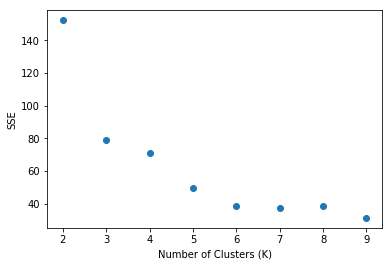

In [20]:
cluster_number = range(2,10)
plt.scatter(cluster_number,errors)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.show()

In [23]:
#Selecting k =3 for kmeans clustering
kmeans = KMeans(featuresCol='features',k=3,)

In [24]:
model = kmeans.fit(final_data)

In [53]:
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   38|
|         0|   62|
+----------+-----+



In [25]:
predictions=model.transform(final_data)

In [26]:
predictions.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'species',
 'features',
 'prediction']

In [27]:
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   14|
|    setosa|         0|   50|
| virginica|         1|   36|
|versicolor|         1|    3|
|versicolor|         2|   47|
+----------+----------+-----+



In [40]:
pandas_df = predictions.toPandas()
pandas_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
5,5.4,3.9,1.7,0.4,setosa,"[5.4, 3.9, 1.7, 0.4]",0
95,5.7,3.0,4.2,1.2,versicolor,"[5.7, 3.0, 4.2, 1.2]",2
132,6.4,2.8,5.6,2.2,virginica,"[6.4, 2.8, 5.6, 2.2]",1
128,6.4,2.8,5.6,2.1,virginica,"[6.4, 2.8, 5.6, 2.1]",1
23,5.1,3.3,1.7,0.5,setosa,"[5.1, 3.3, 1.7, 0.5]",0


In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

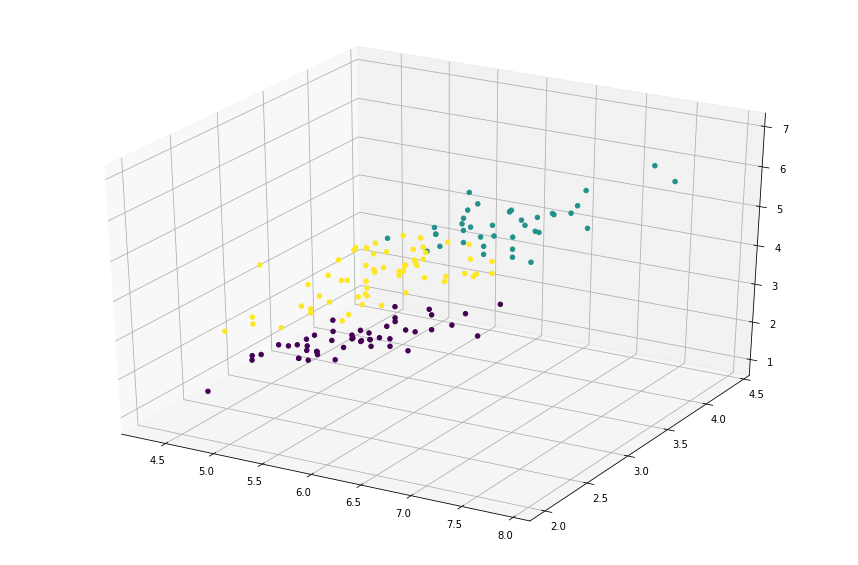

In [50]:
cluster_vis = plt.figure(figsize=(15,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()